# Part 1 Exploratory Data Analysis (EDA)

## Preprocessing Utils

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


np.random.seed(0)  # reproducibility

In [2]:
def class_bar(class_series, class_name, counts_name, label='train'):
    
    x = np.arange(len(class_series))
    rects = plt.bar(x, class_series, alpha=0.5, width=0.5, label=label)   
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom')
    plt.xticks(x)
    plt.xlabel(class_name)
    plt.ylabel('# of %s'%counts_name)
    plt.title('%s distribution, total # of %s: %d'%(class_name, counts_name, class_series.sum()))
    
    plt.legend()
    plt.tight_layout()
    #plt.savefig('bar_%s.png'%class_name)
    plt.show()

In [3]:
def long_tailed_hist(df, object_name, counts_name, label='train'):
    
    plt.hist(df[object_name], bins=200, alpha=0.5, label=label)
    plt.xlabel(object_name)
    plt.ylabel('# of %s'%counts_name)
    plt.yscale('log')  # since long-tailed distribution
    plt.title('%s distribution, total # of %s: %d'%(object_name, counts_name, len(df)))
    
    xmin, xmax = plt.gca().get_xlim()  # get range of x axis
    plt.hlines(1, xmin, xmax, colors='red', linestyles='dashed')
        
    plt.legend()
    plt.tight_layout()
    #plt.savefig('hist_%s.png'%object_name)
    plt.show()

In [4]:
def topk_hbar(df, object_name, tick_name, k=20, ascending=False, label='train'):
    
    df_sorted = df.sort_values(by=[object_name], ascending=ascending, ignore_index=True)
    
    # ascending: 
    # True w.r.t. top k least frequent (or shortest, etc.)
    # False w.r.t. top k most frequent (or longest, etc.)
    topk_tick = df_sorted[:k][tick_name]
    topk_object = df_sorted[:k][object_name]

    x = np.arange(k)
    plt.barh(x, topk_object, alpha=0.5, align='center', height=0.5, tick_label=topk_tick, label=label)
    plt.gca().invert_yaxis()
    plt.xlabel(object_name)
    plt.ylabel(tick_name)
    plt.title('top %d %s'%(k, tick_name))
    
    plt.legend()
    #plt.figure(figsize=(6, 6))
    plt.tight_layout()
    #if ascending:
    #    plt.savefig('hbar_%s_ascending.png'%object_name)
    #else:
    #    plt.savefig('hbar_%s.png'%object_name)
    plt.show()

In [5]:
def get_len_text(df, column_name='text', verbose=True):
    
    # add a column containing len_text (number of words) to the dataframe
    # words in each text are separated by ' ' (space)
    df['len_text'] = df[column_name].apply(lambda x: len(x.split(' ')))  # in situ
    
    if verbose:
        print(df['len_text'].describe().astype(np.int)) 
        
    return df 

In [6]:
import collections


def get_vocab(df, column_name='text', verbose=True):
   
    corpus = ' '.join(df[column_name].to_list())  # string, words are separated by ' ' (space)
    corpus = corpus.split(' ')  # list
    
    word_count = collections.Counter(corpus)  # collections.Counter, key: word, value: word count in corpus
    
    data = {'word': list(word_count.keys()), 'count': list(word_count.values())}
    vocabulary = pd.DataFrame.from_dict(data, orient='columns')
    vocabulary = vocabulary.sort_values(by=['count'], ascending=False, ignore_index=True)
    
    if verbose:      
        print(vocabulary['count'].describe().astype(np.int))
                
    return vocabulary

In [7]:
def separate(text, sep_signs=['3750', '900', '648']):
    
    for sign in sep_signs:
        text = text.replace(sign, 'SEP')
    
    text = [sentence.strip(' ') for sentence in text.split('SEP')]
    
    return list(filter(None, text))

## Train Set

### Load

* Read the `.csv` file of the train set and show the head of the dataframe

In [8]:
%%time

train_df = pd.read_csv('data/train_set.csv', sep='\t', index_col=False)
train_df.head()

CPU times: user 5.65 s, sys: 728 ms, total: 6.38 s
Wall time: 6.42 s


,label,text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


* Check for `NaN` under the entire dataframe of train set

In [9]:
train_df.isnull().values.any()

False

### Analyze

#### Classes

In [10]:
%%time

classes_texts = train_df['label'].value_counts()  # pandas.Series

CPU times: user 3.22 ms, sys: 783 µs, total: 4 ms
Wall time: 2.86 ms


* News text classes distribution

> Imbalanced classes.

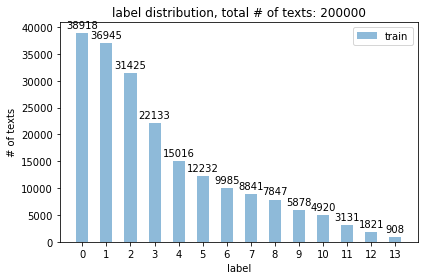

In [11]:
class_bar(classes_texts, 'label', 'texts')

#### Length of text

* Length of news text

>  The shortest length is 2, the longest one is 57921, and the average is 907. The distribution is sparse, the most of the length is approximately from hundreds to thousands.

In [12]:
%%time

train_df = get_len_text(train_df)
train_df.head()

count    200000
mean        907
std         996
min           2
25%         374
50%         676
75%        1131
max       57921
Name: len_text, dtype: int64
CPU times: user 8.02 s, sys: 21.5 ms, total: 8.05 s
Wall time: 8.05 s


,label,text,len_text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...,1057
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...,486
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...,764
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...,1570
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...,307


* Visualize `len_text` distribution and check if there exists straightforward correlation between `len_text` and `label`

> Actually, it is not a long-tailed distribution, there are few examples w.r.t. shorter length (< 10) either.

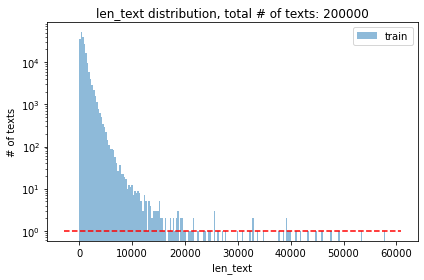

In [13]:
long_tailed_hist(train_df, 'len_text', 'texts', label='train')

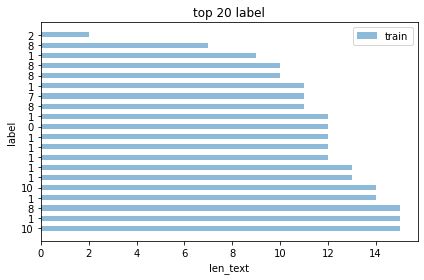

In [14]:
topk_hbar(train_df, 'len_text', 'label', k=20, ascending=True, label='train')

> It seems the longest texts most likely belong to `label` 1.

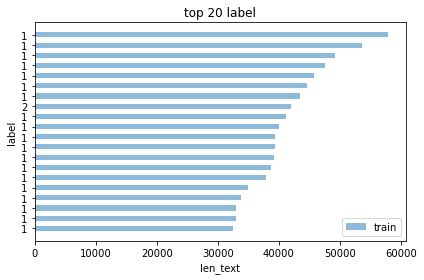

In [15]:
topk_hbar(train_df, 'len_text', 'label', k=20, ascending=False, label='train')

#### Vocabulary-tf

* Vocabulary-tf in the corpus from the train set

> Vocabulary size $V$ is 6869, the most frequent word occurs 7482224 times in the corpus, rare ones only occur once, occurences of most words are approximately from hundreds to thousands.

In [16]:
%%time

train_vocab_tf = get_vocab(train_df)
train_vocab_tf.head()

count       6869
mean       26414
std       146124
min            1
25%           25
50%          459
75%         7258
max      7482224
Name: count, dtype: int64
CPU times: user 35.8 s, sys: 21.8 s, total: 57.7 s
Wall time: 1min 1s


,word,count
0,3750,7482224
1,648,4924890
2,900,3262544
3,3370,2020958
4,6122,1602363


* Visualize `count` distribution and check the most frequent words and rare ones

> Typical long-tailed distribution, quite a few words only occur once in the corpus and the most frequent ones should occur in most texts, we will see. The occurences of "3750", "648", "900" are much greater than any of the remainings, they are supposed to be removed when classifying.

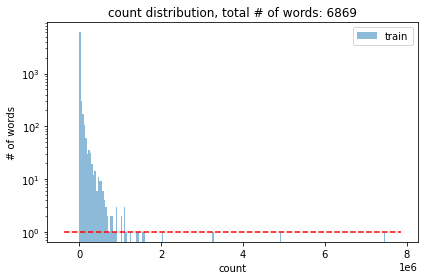

In [17]:
long_tailed_hist(train_vocab_tf, 'count', 'words', label='train')

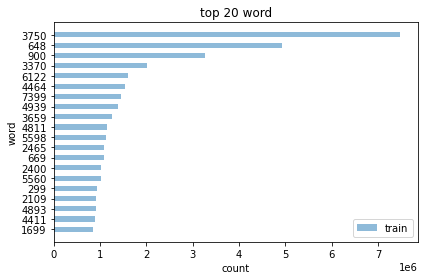

In [18]:
topk_hbar(train_vocab_tf, 'count', 'word', k=20, ascending=False, label='train')

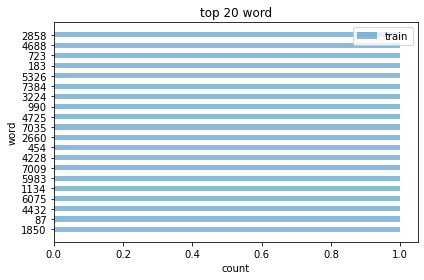

In [19]:
topk_hbar(train_vocab_tf, 'count', 'word', k=20, ascending=True, label='train')

* How many words only occur once in the corpus

In [20]:
len(train_vocab_tf[train_vocab_tf['count'] == 1])

365

#### Vocabulary-df

In [21]:
%%time 

train_df['text_uniq'] = train_df['text'].apply(lambda x: ' '.join(list(set(x.split(' ')))))
train_df['len_text_uniq'] = train_df['text_uniq'].apply(lambda x: len(x.split(' ')))

train_df.head()

CPU times: user 21.9 s, sys: 756 ms, total: 22.7 s
Wall time: 22.8 s


,label,text,len_text,text_uniq,len_text_uniq
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...,1057,7326 2891 3743 5648 2029 1613 5814 2935 5560 2...,408
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...,486,6713 1407 5787 5949 4558 3945 2422 45 7469 556...,208
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...,764,3545 3743 3196 5560 6833 5999 5889 144 4458 15...,338
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...,1570,3809 7465 88 3743 2218 3196 5814 3418 3943 558...,429
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...,307,1324 1610 1407 5787 5430 2145 6314 5814 2541 2...,173


* Vocabulary-df in the corpus from the train set

> Vocabulary size $V$ is 6869, the most frequent word occurs in 197997 texts, rare ones only occur in single text.

In [22]:
%%time

train_vocab_df = get_vocab(train_df, column_name='text_uniq')
train_vocab_df.head()

count      6869
mean       8163
std       21451
min           1
25%          15
50%         266
75%        3781
max      197997
Name: count, dtype: int64
CPU times: user 9.34 s, sys: 1.19 s, total: 10.5 s
Wall time: 10.5 s


,word,count
0,3750,197997
1,900,197653
2,648,191975
3,2465,177310
4,6122,176543


* Visualize `count` distribution and check the most frequent words and rare ones

> Typical long-tailed distribution, quite a few words only occur in single text and the most frequent ones occur in most texts, where "3750", "648", "900" occur in over 95% texts, they are supposed to be removed when classifying.

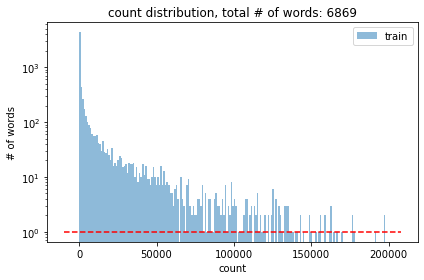

In [23]:
long_tailed_hist(train_vocab_df, 'count', 'words', label='train')

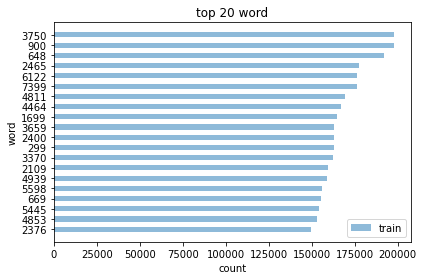

In [24]:
topk_hbar(train_vocab_df, 'count', 'word', k=20, ascending=False, label='train')

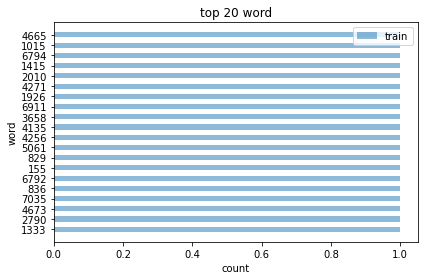

In [25]:
topk_hbar(train_vocab_df, 'count', 'word', k=20, ascending=True, label='train')

* How many words only occur in single text

In [26]:
len(train_vocab_df[train_vocab_df['count'] == 1])

485

#### Top k words in each class

In [27]:
%%time

grouped_vocab_tf = train_df.groupby(['label']).apply(lambda x: get_vocab(x, verbose=False).to_dict()).to_list()

CPU times: user 27.1 s, sys: 2.05 s, total: 29.2 s
Wall time: 29.2 s


* Top 20 words in each class

class 0


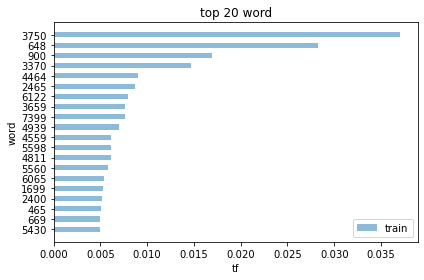

class 1


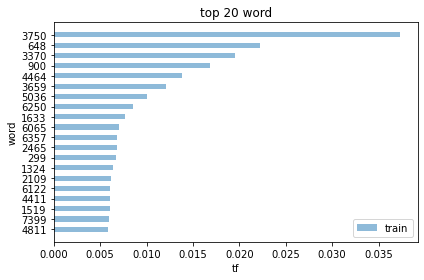

class 2


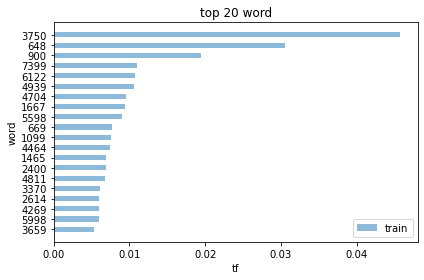

class 3


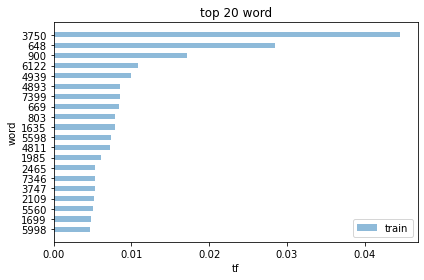

class 4


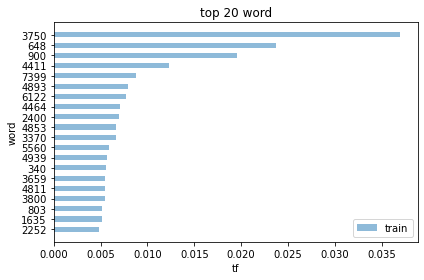

class 5


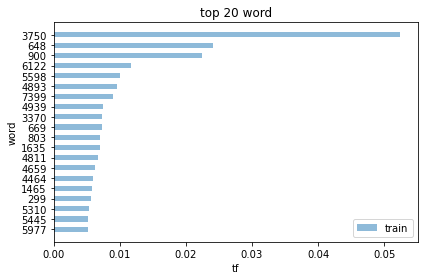

class 6


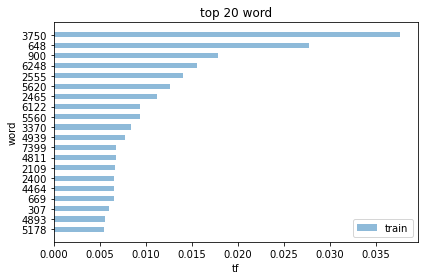

class 7


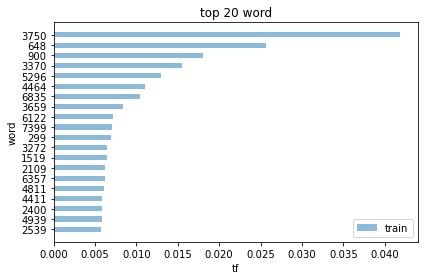

class 8


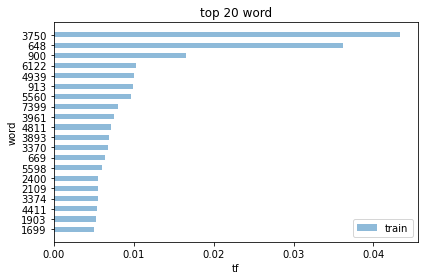

class 9


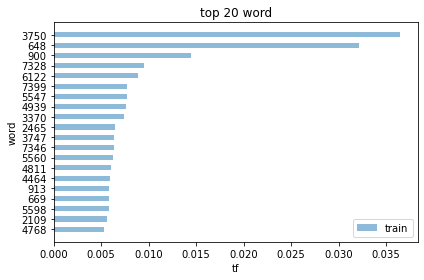

class 10


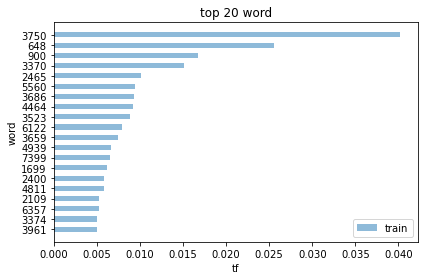

class 11


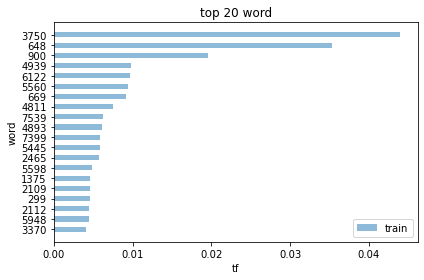

class 12


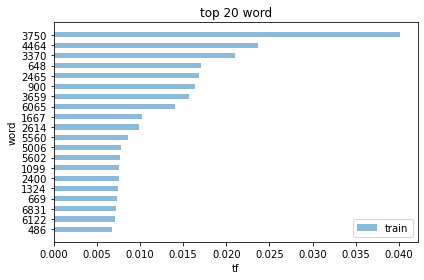

class 13


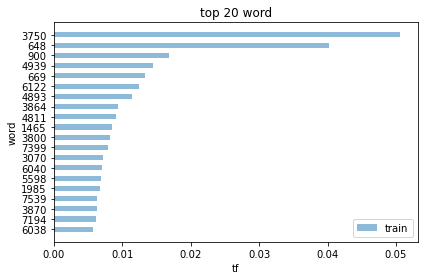

In [28]:
for i, data in enumerate(grouped_vocab_tf):
    
    print('class %d'%i)
    
    vocab_tf = pd.DataFrame.from_dict(data)
    vocab_tf['tf'] = vocab_tf['count'] / vocab_tf['count'].sum()
    topk_hbar(vocab_tf, 'tf', 'word', k=20, ascending=False, label='train')

#### Separate text by "3750", "648", "900"

> "3750", "648", "900" are most likely punctuation, but they may not be the `STOP` sign of a sentence.

In [29]:
%%time

train_df['num_sentence'] = train_df['text'].apply(lambda x: len(separate(x)))

CPU times: user 9.03 s, sys: 12.1 ms, total: 9.05 s
Wall time: 9.05 s


In [30]:
train_df['num_sentence'].describe()

count    200000.000000
mean         79.466030
std          85.383165
min           1.000000
25%          28.000000
50%          56.000000
75%         102.000000
max        3393.000000
Name: num_sentence, dtype: float64

> Number of sentences estimated in a text does NOT show any strong correlation with its label w.r.t. the text.

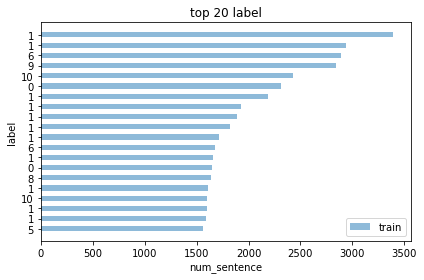

In [31]:
topk_hbar(train_df, 'num_sentence', 'label', k=20, ascending=False, label='train')

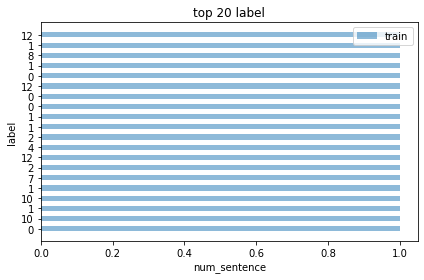

In [32]:
topk_hbar(train_df, 'num_sentence', 'label', k=20, ascending=True, label='train')

> Separating texts into sentences does NOT eliminate or alleviate imbalanced classes.

In [33]:
classes_sentences = train_df.groupby(['label']).apply(lambda x: x['num_sentence'].sum())

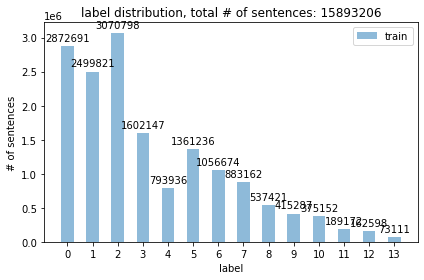

In [34]:
class_bar(classes_sentences, 'label', 'sentences')

## Test Set

### Load

* Read the `.csv` file of the test set and show the head of the dataframe

In [35]:
%%time

test_df = pd.read_csv('data/test_a.csv', sep='\t', index_col=False)
test_df.head()

CPU times: user 1.46 s, sys: 196 ms, total: 1.66 s
Wall time: 1.68 s


,text
0,5399 3117 1070 4321 4568 2621 5466 3772 4516 2...
1,2491 4109 1757 7539 648 3695 3038 4490 23 7019...
2,2673 5076 6835 2835 5948 5677 3247 4124 2465 5...
3,4562 4893 2210 4761 3659 1324 2595 5949 4583 2...
4,4269 7134 2614 1724 4464 1324 3370 3370 2106 2...


* Check for `NaN` under the entire dataframe of train set

In [36]:
train_df.isnull().values.any()

False

### Analyze

#### Length of text

* Length of news text

>  The shortest length is 14, the longest one is 41861, and the average is 909. The distribution is sparse, most of the length is approximately from hundreds to thousands.

In [37]:
%%time

test_df = get_len_text(test_df)
test_df.head()

count    50000
mean       909
std       1032
min         14
25%        370
50%        676
75%       1133
max      41861
Name: len_text, dtype: int64
CPU times: user 2.04 s, sys: 9.28 ms, total: 2.05 s
Wall time: 2.05 s


,text,len_text
0,5399 3117 1070 4321 4568 2621 5466 3772 4516 2...,607
1,2491 4109 1757 7539 648 3695 3038 4490 23 7019...,1861
2,2673 5076 6835 2835 5948 5677 3247 4124 2465 5...,901
3,4562 4893 2210 4761 3659 1324 2595 5949 4583 2...,3786
4,4269 7134 2614 1724 4464 1324 3370 3370 2106 2...,316


* Visualize `len_text` distribution

> Similar to train set.

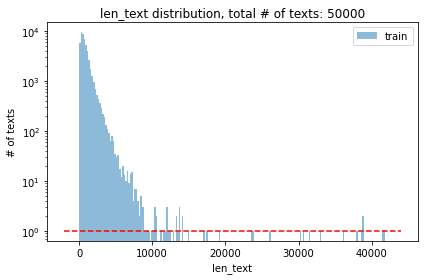

In [38]:
long_tailed_hist(test_df, 'len_text', 'texts', label='train')

#### Vocabulary-tf

* Vocabulary-tf in the corpus from the test set

> Vocabulary size $V$ is 6203, the most frequent word occurs 1879488 times in the corpus, rare ones only occur once, occurences of most words are approximately from hundreds to thousands.

In [39]:
%%time

test_vocab_tf = get_vocab(test_df)
test_vocab_tf.head()

count       6203
mean        7333
std        38529
min            1
25%           16
50%          182
75%         2407
max      1879488
Name: count, dtype: int64
CPU times: user 6.95 s, sys: 790 ms, total: 7.74 s
Wall time: 7.71 s


,word,count
0,3750,1879488
1,648,1232522
2,900,818765
3,3370,511436
4,6122,402213


* Visualize `count` distribution and check the most frequent words and rare ones

> Typical long-tailed distribution, quite a few words only occur once in the corpus and the most frequent ones should occur in most texts. The occurences of "3750", "648", "900" are much greater than any of the remainings, they are supposed to be removed when classifying.

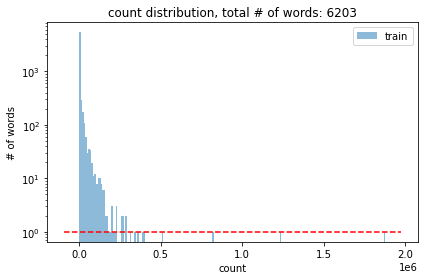

In [40]:
long_tailed_hist(test_vocab_tf, 'count', 'words', label='train')

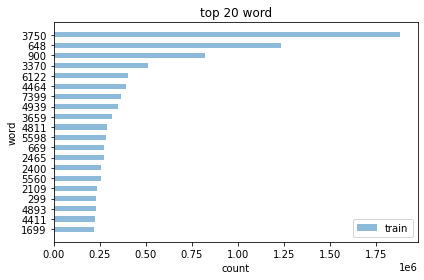

In [41]:
topk_hbar(test_vocab_tf, 'count', 'word', k=20, ascending=False, label='train')

* How many words only occur once in the corpus

In [42]:
len(test_vocab_tf[test_vocab_tf['count'] == 1])

389

#### Vocabulary-df

In [43]:
%%time 

test_df['text_uniq'] = test_df['text'].apply(lambda x: ' '.join(list(set(x.split(' ')))))
test_df['len_text_uniq'] = test_df['text_uniq'].apply(lambda x: len(x.split(' ')))

test_df.head()

CPU times: user 5.52 s, sys: 35.2 ms, total: 5.55 s
Wall time: 5.56 s


,text,len_text,text_uniq,len_text_uniq
0,5399 3117 1070 4321 4568 2621 5466 3772 4516 2...,607,1324 3809 1407 2990 3772 7533 5560 4089 2073 3...,222
1,2491 4109 1757 7539 648 3695 3038 4490 23 7019...,1861,3661 5787 3743 1613 3196 5560 7019 5999 2197 5...,439
2,2673 5076 6835 2835 5948 5677 3247 4124 2465 5...,901,1613 3196 6833 3270 2444 2456 2642 4893 5780 6...,309
3,4562 4893 2210 4761 3659 1324 2595 5949 4583 2...,3786,6111 7326 1407 2891 951 2988 5560 3030 4310 55...,680
4,4269 7134 2614 1724 4464 1324 3370 3370 2106 2...,316,1324 2525 2722 4261 1407 265 2891 5430 88 2218...,148


* Vocabulary-df in the corpus from the test set

> Vocabulary size $V$ is 6203, the most frequent word occurs in 49455 texts, rare ones only occur in single text.

In [44]:
%%time

test_vocab_df = get_vocab(test_df, column_name='text_uniq')
test_vocab_df.head()

count     6203
mean      2263
std       5599
min          1
25%          9
50%        107
75%       1282
max      49455
Name: count, dtype: int64
CPU times: user 2.09 s, sys: 88.9 ms, total: 2.18 s
Wall time: 2.17 s


,word,count
0,3750,49455
1,900,49366
2,648,47966
3,2465,44309
4,6122,44123


* Visualize `count` distribution and check the most frequent words and rare ones

> Typical long-tailed distribution, quite a few words only occur in single text and the most frequent ones occur in most texts, where "3750", "648", "900" occur in over 95% texts, they are supposed to be removed when classifying.

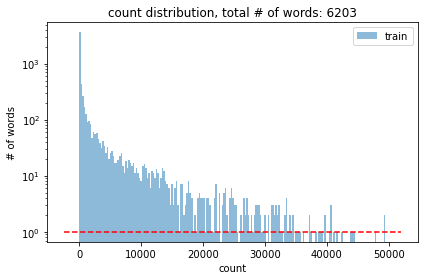

In [45]:
long_tailed_hist(test_vocab_df, 'count', 'words', label='train')

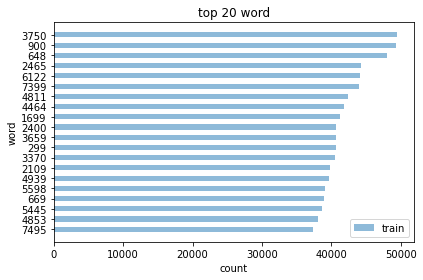

In [46]:
topk_hbar(test_vocab_df, 'count', 'word', k=20, ascending=False, label='train')

* How many words only occur in single text

In [47]:
len(test_vocab_df[test_vocab_df['count'] == 1])

541

#### Total vocabulary

> Out-of-vocabulary (OOV) issue.

In [48]:
vocab = list(set(train_vocab_tf['word'].to_list() + test_vocab_tf['word'].to_list()))

print(len(vocab))

6977


## Summary

* Imbalanced classes.

* In both train and test set, most of news texts are quite long, the average length (number of words) is around 900, the shortest one is 2, the longest one is up to 57921.

* Out-of-vocabulary (OOV) issue. Total vocabulary size in train and test a set is 6977 while there are 6869 words in train and 6203 words in test a.

* In both train and test set, vocabulary tf and df are typical long-tailed distributions, i.e., quite a few words only occur in single text, even only occur once in the corpus, and the most frequent ones occur in the most texts, where "3750", "648", "900" occur in over 95% texts, they are most likely punctuactions and are supposed to be removed when classifying.